In [29]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore the ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [30]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Object Detection
#### Introduction to Object Detection

Object detection is a computer vision task that involves identifying and locating objects within an image or video. Unlike image classification, which only assigns a label to an image, object detection provides both the class label and the bounding box coordinates of objects present in the image.

### YOLO (You Only Look Once)

YOLO (You Only Look Once) is a popular real-time object detection algorithm known for its speed and accuracy. Unlike traditional object detection methods that use region proposals, YOLO treats object detection as a single regression problem, predicting bounding boxes and class probabilities directly from the image in one pass.

#### How YOLO Works

1. **Image Grid Division**: The input image is divided into an \( S \times S \) grid.
2. **Bounding Box Prediction**: Each grid cell predicts a fixed number of bounding boxes along with confidence scores.
3. **Class Probability Prediction**: Each bounding box is assigned a class label with a probability.
4. **Non-Maximum Suppression (NMS)**: Overlapping boxes are filtered to retain the most confident detections.

#### Advantages of YOLO

- **Fast Inference**: YOLO can process images in real-time, making it suitable for applications like autonomous driving and video surveillance.
- **End-to-End Training**: Unlike region-based methods, YOLO is trained as a single neural network, making it more efficient.
- **Global Context Awareness**: Since YOLO processes the entire image at once, it reduces false positives compared to sliding window or region-based methods.

#### Variants of YOLO

- **YOLOv1-v3**: Initial versions that introduced the concept and improved accuracy.
- **YOLOv4**: Optimized for better speed and precision.
- **YOLOv5**: A widely used implementation with improvements in efficiency.
- **YOLOv7 & YOLOv8**: State-of-the-art versions focusing on faster inference and higher detection accuracy.

Due to its real-time performance and high accuracy, YOLO is widely used in applications such as autonomous vehicles, security systems, and medical diagnostics.

## Applying YOLO algorithm
We are going to apply a YOLO device that would be applicable for a self driving car, if it knows what objects are around him on the high way it can help out driving safely.
![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*XNhy_ZX7h8D8eJrDuBkTWQ.gif)

### Take a look in the data

In [31]:
!pip install opencv-python


In each algorithm we have an input (features) and a output (target), we can define them also als X, y respectively. Now lets have a quick dive into the dataset before we apply YOLO.


Image files in the folder: 63


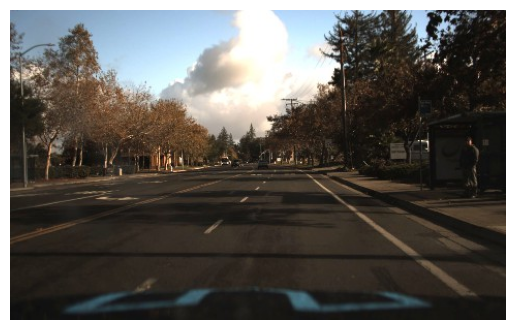

In [32]:
import os
import cv2
import matplotlib.pyplot as plt

# Get the current directory
current_dir = os.getcwd()

# Construct the base path dynamically
base_path = os.path.join(current_dir, 'images')

# Get the first image file in the folder
image_files = os.listdir(base_path)  # List all files in the folder

print("Image files in the folder:", len(image_files))  # Print the list of image files
first_image_path = os.path.join(base_path, image_files[0])  # Get the path of the first image

# Read the first image
image = cv2.imread(first_image_path)

# Convert from BGR (OpenCV) to RGB (matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the first image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


Remember the lecture? We had different vectors that we used as targets. Now, we will gather data from the images, using the data from the center of the grid, which corresponds to a specific label that we want our model to predict. 


In [33]:
from sklearn.utils import shuffle
import pandas as pd

#Load the labels which are vectors with a reference to the image
df_target = pd.read_csv('labels_train.csv')
df_target = shuffle(df_target, random_state=34)
df_target.head()

,frame,xmin,xmax,ymin,ymax,class_id
116076,1479504831903792057.jpg,421,479,126,166,1
60314,1478898631952020193.jpg,0,32,148,179,1
19290,1478732226901726005.jpg,120,170,121,162,2
4385,1478020436697344349.jpg,456,471,132,163,4
67693,1479499187019138898.jpg,235,258,137,158,1


**What are these columns?**

The filename is stored (frame), the class it belongs to (class_id) and some bounding box coordinates.
A bounding box is a rectangular region used to identify and isolate an object within an image. **It is defined by four coordinates: xmin, xmax, ymin, and ymax.** These coordinates specify the horizontal and vertical extents of the box, effectively creating a frame around the object of interest. In the code, these coordinates are stored for each image to precisely indicate where the object is located within the image. By keeping these bounding box coordinates, the program can later use them to draw or highlight the detected object, making it essential for tasks like object detection and image classification.

In [34]:
print(df_target.shape) # print the shape of the dataframe


(132406, 6)


This dataset is mostly a practice and training aspect for the subject of YOLO. Let's figure out how many different classes there are in the dataset and how often they appear:

In [35]:
classes = df_target.class_id.unique()
print(classes)

[1 2 4 3 5]


In [36]:
df_target['class_id'].value_counts()

class_id
1    101314
5     12700
3     10637
2      6313
4      1442
Name: count, dtype: int64

The class_id labels seems to be: 'car', 'truck', 'pedestrian', 'bicyclist', 'light'

In [37]:
#Transfer the numbers into the 5 different classes 
labels = { 1:'car', 2:'truck', 3:'person', 4:'bicycle', 5:'traffic light'}

In [38]:
boxes = {}
images = {}

print(df_target.head())

for class_id in classes:
    # get all the rows for the current class
    print(f"Processing class {class_id}...")
    target_rows = df_target[df_target['class_id'] == class_id]
    print(f"Number of rows for class {class_id}: {len(target_rows)}")
    # Check if there are any rows for the current class. If not, skip to the next class   
    if target_rows.empty:
        print(f"No data found for class {class_id}. Skipping.")
        continue

    # Search for first image on disk from the dataframe
    image_found = False
    for _, row in target_rows.iterrows():
        file_name = row['frame']
        image_path = os.path.join(base_path, file_name)
        
        if not os.path.exists(image_path):
            continue
        
        print(f"Found image {image_path} for class {class_id}.")

        # Lees de afbeelding
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image {image_path}. Trying next row...")
            continue
        else:
            image_found = True
            break
        
    if image_found:
        print(f"Image found AND read for class {class_id}: {image_path}")
        # Convert from BGR (OpenCV) to RGB (matplotlib)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        images[class_id] = image_rgb
        boxes[class_id] = [
            int(row['xmin']), 
            int(row['xmax']), 
            int(row['ymin']), 
            int(row['ymax'])
        ]
        


                          frame  xmin  xmax  ymin  ymax  class_id
116076  1479504831903792057.jpg   421   479   126   166         1
60314   1478898631952020193.jpg     0    32   148   179         1
19290   1478732226901726005.jpg   120   170   121   162         2
4385    1478020436697344349.jpg   456   471   132   163         4
67693   1479499187019138898.jpg   235   258   137   158         1
Processing class 1...
Number of rows for class 1: 101314
Found image C:\Users\oldma\Desktop\avans1.4-portfolio\edu material\images\1478019957687018435.jpg for class 1.
Image found AND read for class 1: C:\Users\oldma\Desktop\avans1.4-portfolio\edu material\images\1478019957687018435.jpg
Processing class 2...
Number of rows for class 2: 6313
Found image C:\Users\oldma\Desktop\avans1.4-portfolio\edu material\images\1478019959187829768.jpg for class 2.
Image found AND read for class 2: C:\Users\oldma\Desktop\avans1.4-portfolio\edu material\images\1478019959187829768.jpg
Processing class 4...
Number o

**What is happening here with the colors of the image?**

When an image is loaded using OpenCV (cv2.imread), it is automatically stored in BGR (Blue, Green, Red) format, which is OpenCV's default color ordering. However, most image processing and visualization libraries, such as matplotlib, use RGB (Red, Green, Blue) format. To ensure the image colors are displayed correctly, the code converts the image from BGR to RGB using cv2.cvtColor(image, cv2.COLOR_BGR2RGB). This simply reorders the color channels of the image, making it compatible with other libraries that expect RGB format.

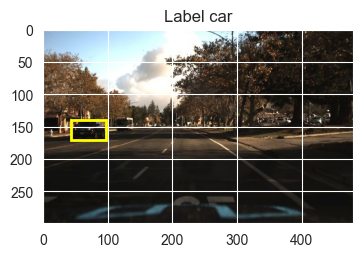

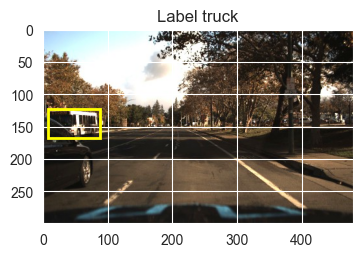

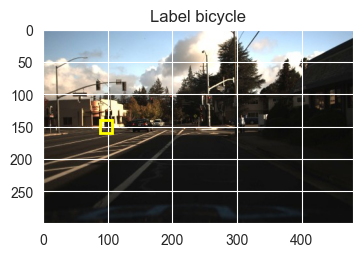

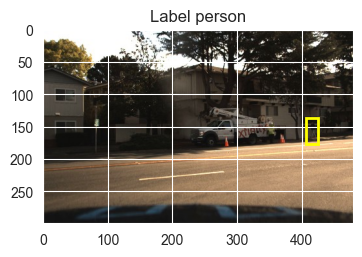

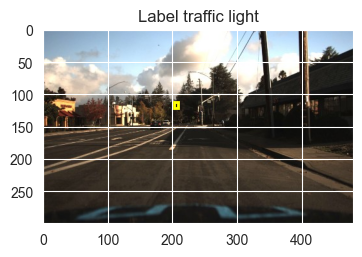

In [39]:
## Let's visualise the 5 different classes that exists with their bounding boxes in a image 
for class_id in classes:
    xmin, xmax, ymin, ymax = boxes[class_id][0], boxes[class_id][1], boxes[class_id][2], boxes[class_id][3]

    plt.figure(figsize=(4, 6))
    plt.title("Label " + labels[class_id])
    plt.imshow(images[class_id])
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))

    plt.show() 

### Applying YOLO on the dataset

Lets load in a YOLO v8 model therefor we need first to install the package ultralitics do this by using '!pip install ultralytics'. Afterwards we load in the necessary packages to visualise the images.

In [40]:
!pip install ultralytics;

In [41]:
from ultralytics import YOLO
import PIL 
from PIL import Image
from IPython.display import display
import os 
import pathlib 


In [42]:
# Load the YOLO v8 model
model = YOLO("yolov8m.pt")

Let's select a random image from the 100 images in the "images" folder to use as an example.

In [43]:
import numpy as np

np.random.seed(80) 
random_num=np.random.randint(0, 100)
example = os.path.join(base_path, image_files[random_num])  # Get the path of the first image

Now since we have an image and we can let YOLO do a prediction on the dataset. You can improve YOLO's performance, by adjusting the confidence (conf) and IoU thresholds.

Increasing these thresholds will:
- Higher Confidence: Increases accuracy by being more selective, but may overlook some valid detections.
- Higher IoU: Ensures stricter overlap criteria, reducing incorrect identifications, but may exclude some correct ones if the overlap isn't sufficient

In [44]:
results = model.predict(source=example, save=True, conf=0.2, iou=0.2) # change conf and iou


image 1/1 C:\Users\oldma\Desktop\avans1.4-portfolio\edu material\images\1478019976185898081.jpg: 416x640 2 persons, 3 cars, 7 traffic lights, 70.0ms
Speed: 0.8ms preprocess, 70.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict5


In [45]:
# Return the information (class, coordinates of the box and the confidence) of each predicted object
result = results[0]
for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    print("Object type:", class_id)
    print("Coordinates:", cords)
    print("Probability:", conf)
    print("---")

Object type: car
Coordinates: [76, 133, 137, 168]
Probability: 0.9
---
Object type: car
Coordinates: [309, 127, 378, 149]
Probability: 0.83
---
Object type: traffic light
Coordinates: [9, 47, 21, 70]
Probability: 0.73
---
Object type: traffic light
Coordinates: [1, 90, 8, 103]
Probability: 0.72
---
Object type: car
Coordinates: [156, 137, 181, 152]
Probability: 0.72
---
Object type: traffic light
Coordinates: [71, 49, 81, 71]
Probability: 0.55
---
Object type: traffic light
Coordinates: [36, 88, 41, 101]
Probability: 0.51
---
Object type: traffic light
Coordinates: [270, 78, 277, 96]
Probability: 0.49
---
Object type: person
Coordinates: [387, 116, 416, 177]
Probability: 0.43
---
Object type: traffic light
Coordinates: [65, 118, 70, 129]
Probability: 0.42
---
Object type: person
Coordinates: [387, 123, 393, 156]
Probability: 0.25
---
Object type: traffic light
Coordinates: [189, 85, 196, 101]
Probability: 0.25
---


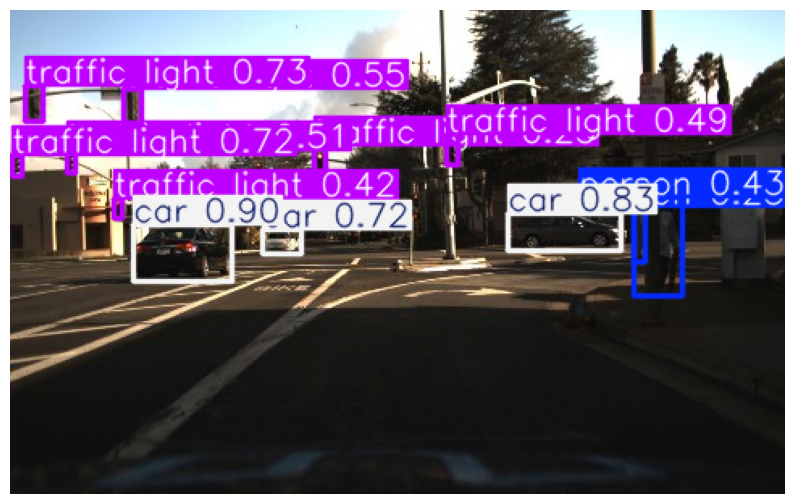

In [46]:
# Plotting the predicted results
plot = results[0].plot()

# Convert the plot from BGR to RGB
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

# Create a larger figure size
plt.figure(figsize=(10, 10))  
plt.imshow(plot)
plt.axis('off')
plt.show()

Now, let's visualize the actual objects in the image, identify their classes, and show their locations and orientations. We'll plot these details on the image.

In [47]:
# Get only the filename
filename = os.path.basename(example)

In [48]:
# Return the target data corresponding to the image
df_target[df_target['frame']==filename]

,frame,xmin,xmax,ymin,ymax,class_id
294,1478019976185898081.jpg,63,71,116,130,5
295,1478019976185898081.jpg,75,138,131,168,1
301,1478019976185898081.jpg,305,385,124,151,1
300,1478019976185898081.jpg,268,279,76,97,5
299,1478019976185898081.jpg,247,255,110,123,5
298,1478019976185898081.jpg,188,196,85,100,5
296,1478019976185898081.jpg,149,158,91,104,5
297,1478019976185898081.jpg,154,177,137,151,1


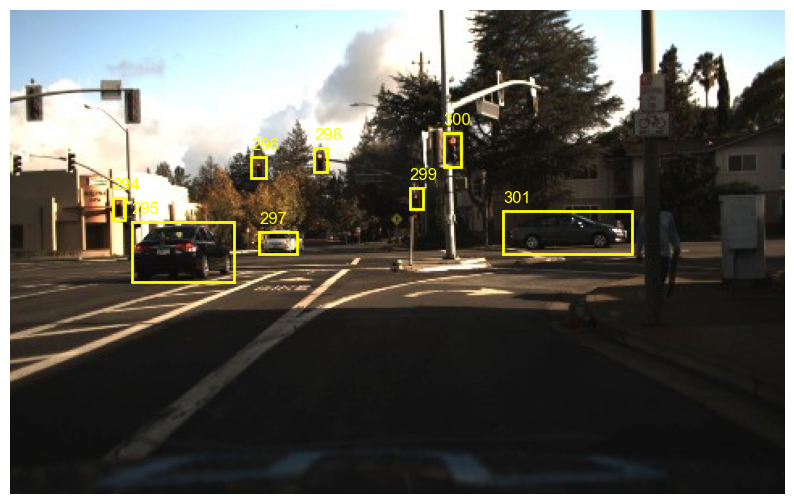

In [49]:
# Find all matching rows in df_target for this filename
matching_rows = df_target[df_target['frame'] == filename]

# Construct the full image path
image_path = os.path.join(base_path, filename)

# Read and convert the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)

for index, row in matching_rows.iterrows():
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']
    
    plt.gca().add_patch(
        plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                      edgecolor='yellow', fill=False, linewidth=2)
    )

    # Add the index number above the bounding box
    plt.text(xmin, ymin - 5, f"{index}", color='yellow', 
             fontsize=12, backgroundcolor='none')

plt.axis('off')  # Hide axes for a cl
plt.show()

We need to transform YOLO's predicted bounding boxes into the format required for our dataset. YOLO uses its own object IDs, which are mapped to custom class IDs (1 to 5) for consistency with our dataset. The code extracts YOLO's center coordinates (xywh) and converts them into xmin, ymin, xmax, ymax format. Then, it maps YOLO's class IDs to our custom class IDs using a predefined dictionary. Finally, the processed predictions are stored in a pandas DataFrame for further analysis

In [50]:
import pandas as pd

# Define the mapping from YOLO class IDs to the new custom label IDs
yolo_to_custom = {
    2: 1,  # Car -> Class ID 2 maps to 1
    7: 2,  # Truck -> Class ID 7 maps to 2
    0: 3,  # Person -> Class ID 0 maps to 3
    1: 4,  # Bicycle -> Class ID 1 maps to 4
    9: 5   # Traffic light -> Class ID 9 maps to 5
}

# Initialize a list to hold the rows of the DataFrame
predictions_data = []

# Example: Extract YOLO predictions and ground truth for each frame (this should come from results[0])
for i, box in enumerate(results[0].boxes):  # Iterate through each prediction
    frame = filename  # You would retrieve the frame name here
    
    # Extract xywh (center_x, center_y, width, height)
    center_x, center_y, width, height = box.xywh[0].int().tolist()  # Convert to integers
    
    # Convert to xmin, ymin, xmax, ymax
    xmin = int(center_x - width / 2)
    ymin = int(center_y - height / 2)
    xmax = int(center_x + width / 2)
    ymax = int(center_y + height / 2)
    
    # Convert class_id tensor to integer
    class_id = box.cls.int().item()  # Convert class tensor to integer
    
    # Map YOLO class_id to the custom label ID
    custom_class_id = yolo_to_custom.get(class_id, -1)  # Get the custom label ID (-1 for unknown)
    
    # Append the prediction data to the list, now without the class_label
    predictions_data.append([frame, xmin, xmax, ymin, ymax, custom_class_id])

# Convert the predictions data to a pandas DataFrame
predictions_df = pd.DataFrame(predictions_data, columns=['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])

# Show the resulting DataFrame
predictions_df

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019976185898081.jpg,75,136,132,167,1
1,1478019976185898081.jpg,308,377,127,149,1
2,1478019976185898081.jpg,8,19,47,69,5
3,1478019976185898081.jpg,1,7,90,102,5
4,1478019976185898081.jpg,156,180,136,151,1
5,1478019976185898081.jpg,71,81,49,70,5
6,1478019976185898081.jpg,36,40,87,100,5
7,1478019976185898081.jpg,269,276,78,96,5
8,1478019976185898081.jpg,386,415,116,176,3
9,1478019976185898081.jpg,64,69,117,128,5


### Lets evaluate the default YOLO algorithm

Let's now examine the performance of YOLO. While there are various methods to evaluate its performance, most of them rely on the **confusion matrix**. We'll build a confusion matrix to assess our predicted data. To understand the importance of this, consider the scenario with Tim, who was fined for holding a phone when he actually wasn’t this by the YOLO algorithm which was used by the dutch police. [Handsfree detection algorithm at the dutch police](https://nippur.nl/tim-versus-politie-algoritme/) 

![](https://nippur.nl/wp-content/uploads/2024/02/confusion-matrix.png)

In addition to that, we also covered the concept of **Intersection of Union (IoU)**. Let's go ahead and calculate the IoU for this example as well.


![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*za4Hpz8SDUdWg-S6goL4yg.jpeg)

In [51]:
# Function to calculate IoU
def compute_iou(pred_box, gt_box):
    x1, y1, x2, y2 = max(pred_box[0], gt_box[0]), max(pred_box[1], gt_box[1]), min(pred_box[2], gt_box[2]), min(pred_box[3], gt_box[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

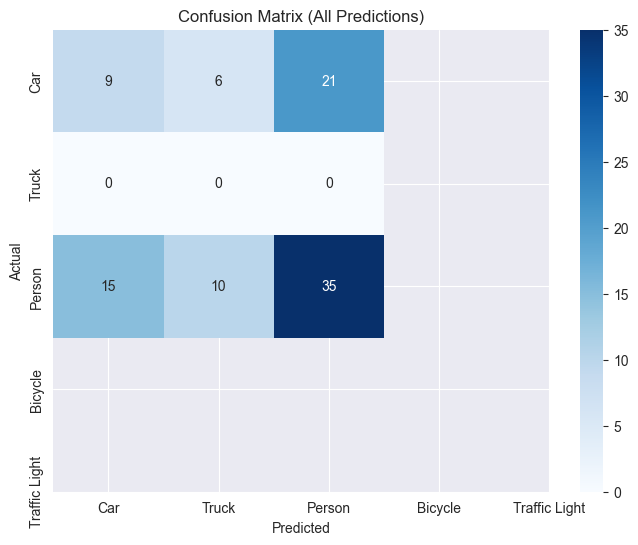


IoU per object:
    prediction_index  ground_truth_index       iou
0                  0                 294  0.000000
1                  0                 295  0.915916
2                  0                 301  0.000000
3                  0                 300  0.000000
4                  0                 299  0.000000
..               ...                 ...       ...
91                11                 300  0.000000
92                11                 299  0.000000
93                11                 298  0.666667
94                11                 296  0.000000
95                11                 297  0.000000

[96 rows x 3 columns]


In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ground_truth_df = df_target[df_target['frame'] == filename]

# List to hold indices, ground truth, and IoU values
iou_info = []

# Calculate IoU without applying a threshold
for i, pred in predictions_df.iterrows():
    frame = pred['frame']
    pred_box = [pred['xmin'], pred['ymin'], pred['xmax'], pred['ymax']]
    pred_class = pred['class_id']
    
    # Find the corresponding ground truth
    gt_boxes = ground_truth_df[ground_truth_df['frame'] == frame]
    
    for j, gt in gt_boxes.iterrows():
        gt_box = [gt['xmin'], gt['ymin'], gt['xmax'], gt['ymax']]
        gt_class = gt['class_id']
        
        # Calculate IoU between prediction and ground truth
        iou = compute_iou(pred_box, gt_box)
        
        # Store the index, ground truth, and IoU for all predictions
        iou_info.append([i, j, pred_class, gt_class, iou])

# Create DataFrame to show the IoU results with prediction and ground truth indices
iou_df = pd.DataFrame(iou_info, columns=['prediction_index', 'ground_truth_index', 'pred_class_id', 'gt_class_id', 'iou'])

# Now, we can calculate the confusion matrix for all predictions (no threshold)
predicted_classes = iou_df['pred_class_id'].values
actual_classes = iou_df['gt_class_id'].values

# Compute confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Car', 'Truck', 'Person', 'Bicycle', 'Traffic Light'], yticklabels=['Car', 'Truck', 'Person', 'Bicycle', 'Traffic Light'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (All Predictions)')
plt.show()

# Output the IoU values for all predictions
print("\nIoU per object:")
print(iou_df[['prediction_index', 'ground_truth_index', 'iou']])


# Fine-Tuning YOLO and Labeling Your Own Data  

YOLO is already a strong object detection model, but in some cases, you may want to fine-tune it to improve performance for your specific use case. One way to do this is by using pre-trained YOLO models provided by platforms like **[Roboflow](https://roboflow.com/)**, which offer easy-to-use training pipelines. Alternatively, if your dataset is not labeled yet, you’ll need to label your own data before training. **[Explanation video about labeling](https://www.youtube.com/watch?v=a3SBRtILjPI)**

##### Labeling Your Own Data  

Labeling is the process of defining the target objects in your dataset by drawing bounding boxes around them and specifying their class. This is essential for training an object detection model. One of the most popular tools for labeling data is Roboflow, which allows you to upload images, annotate them, and export them in formats compatible with YOLO. To get started, sign up for a Roboflow account.  

##### Other Labeling Tools  

- LabelImg – A simple, open-source tool for annotating images.  
  - [GitHub - LabelImg](https://github.com/HumanSignal/labelImg)  

- CVAT (Computer Vision Annotation Tool) – A powerful tool with advanced features for annotating images and videos.  
  - [CVAT.org](https://cvat.org/) | [GitHub - CVAT](https://github.com/opencv/cvat)  

- LabelMe – Another open-source annotation tool focused on polygon-based annotations.  
  - [GitHub - LabelMe](https://github.com/wkentaro/labelme)  

### Roboflow API
To make use of a pre-trained model on Roboflow, you need to establish a connection with their cloud-based inference service. This requires:

1) Insert your specific project API key to authenticate (Go to https://app.roboflow.com/login, login or create an account and after that-> Settings to get the private API key)
2) Once connected, you'll be able to view prediction results

In this example, we connect with our own pre-trained YOLO model which has been trained on custom-labeled traffic signs dataset. The model is capable of detecting and classifying four different categories of traffic signs.   ![](https://www.mdpi.com/applsci/applsci-13-04793/article_deploy/html/images/applsci-13-04793-g001.png)


In [53]:
!pip install inference-sdk

[inference_sdk](https://inference.roboflow.com/inference_helpers/inference_sdk/#getting-server-info)

In [54]:
# import the inference-sdk
from inference_sdk import InferenceHTTPClient

# initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="Ur7bBQIVjsHY4w5LxB8i"  # Replace with your actual private API key
)

# infer on a local image
result1 = CLIENT.infer("11502.png", model_id="traffic-signs-2-k9pcv/1")

In [55]:
result1

{'inference_id': '8fdc0320-b1e6-4e37-961b-dca2aeef427d',
 'time': 0.10256061900008717,
 'image': {'width': 62, 'height': 93},
 'predictions': [{'x': 31.0,
   'y': 46.0,
   'width': 56.0,
   'height': 72.0,
   'confidence': 0.7115204334259033,
   'class': 'Priority',
   'class_id': 1,
   'detection_id': '60e47b83-9474-4ad7-96bf-abd2781b8943'}]}

**What is displayed?**

The inference result shows that an image of size 62x93 pixels was analyzed in 0.13 seconds, and one object was detected. The detected object is of class "Priority" with a confidence score of 71.15%. The object's bounding box is centered at (31, 46) with a width of 56 and height of 72. The result is associated with an inference ID and a detection ID for tracking.

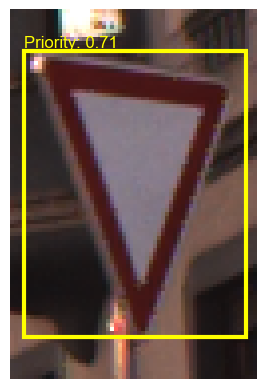

In [56]:
# Load image using OpenCV
image = cv2.imread('11502.png')
if image is None:
    raise FileNotFoundError("Image not found.")

# Resize image (assuming result1 contains 'image' dimensions)
image_resized = cv2.resize(image, (result1['image']['width'], result1['image']['height']))

# Convert BGR image to RGB for matplotlib
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

# Create a figure and axis for matplotlib
fig, ax = plt.subplots()

# Display the image using matplotlib
ax.imshow(image_rgb)

# Draw bounding boxes and text on the image using matplotlib
for index, pred in enumerate(result1['predictions']):
    xmin, ymin, xmax, ymax = map(int, [pred['x'] - pred['width'] // 2, pred['y'] - pred['height'] // 2,
                                      pred['x'] + pred['width'] // 2, pred['y'] + pred['height'] // 2])

    # Add bounding box using matplotlib patches
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                               edgecolor='yellow', fill=False, linewidth=3))

    # Add text above the bounding box (adjust ymin to place it above)
    label = f"{pred['class']}: {pred['confidence']:.2f}"
    ax.text(xmin, ymin-1 , label, color='yellow', fontsize=12, backgroundcolor='none')

# Hide axes for a cleaner view
ax.axis('off')

# Show the image with bounding boxes and text using matplotlib
plt.show()


### Portfolio assignment 22
30 min: Let Yolov8 do predictions on your own choosen dataset (look for a nice images dataset on Roboflow or Kaggle or....).
- Load your data in and have a quick look
- Let YOLO predict from one of your images the objects
- Describe if the predictions are correct according to you, just by looking at the images.

![](https://i.imgur.com/0v1CGNV.png)<br>
Assumption: ...<br>
Finding: ...<br>



##### Extra info

When you dowloaded a dataset from the internet often there is a yaml file. 
YAML (Yet Another Markup Language) is a **human-readable** format used for configuration files. It is simple, supports key-value pairs, and is widely used in machine learning setups.  

YOLO uses YAML to define:  
- **Dataset paths** (train/val images)  
- **Number of classes** (`nc`)  
- **Class names** (`names`)  

It is preferred because it is lightweight, easy to edit, and Python-friendly.  